# Set up the environment

In [1]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn
from sklearn.manifold import TSNE, MDS

# Define a function to create a filename


In [2]:
def getFileName(name, n_samples, model_name, layer_name):
    return name \
        + "_{}_".format(n_samples) \
        + "_{}_".format(model_name) \
        + "_{}".format(layer_name)  \
        + ".npy"   

# Get the model and layers' names and load the model RDM

In [25]:
multiple_models = 1 #comparing within a model or between models; 1 = between, 0 = within
trained_on_1 = 'places'
trained_on_2 = 'imagenet'
tested_on = 'imagenet'

#load the np file containing the shape of the activations
ROOT_PATH = '/mnt/raid/ni/agnessa/RSA/'
layers_path = '/mnt/raid/ni/agnessa/RSA/'

if trained_on_1 == 'imagenet':
    path_data_1 = 'Objects/'
    if tested_on == 'imagenet':
        NR_OF_SAMPLES = 10000
    elif tested_on == 'places365':
        NR_OF_SAMPLES = 10220

elif trained_on_1 == 'places':
    if tested_on == 'imagenet':
        NR_OF_SAMPLES = 10000
        path_data_1 = 'Scenes/ImageNet/'
    elif tested_on == 'places365':
        NR_OF_SAMPLES = 10220
        path_data_1 = 'Scenes/Places365/'

if trained_on_2 == 'imagenet':
    path_data_2 = 'Objects/'
    if tested_on == 'imagenet':
        NR_OF_SAMPLES = 10000
    elif tested_on == 'places365':
        NR_OF_SAMPLES = 10220

elif trained_on_2 == 'places':
    if tested_on == 'imagenet':
        NR_OF_SAMPLES = 10000
        path_data_2 = 'Scenes/ImageNet/'
    elif tested_on == 'places365':
        NR_OF_SAMPLES = 10220
        path_data_2 = 'Scenes/Places365/'
    
arch_1 = 'resnet50'
json_file_layers=os.path.join(layers_path + 'layer_names/',arch_1 + '.json')

#for resnets, use the selected layers file
if 'res' in arch_1:
    json_file_layers=os.path.join(layers_path + 'layer_names/',arch_1 + '_selected_layers.json')
with open(json_file_layers, "r") as fd:
    selected_layers_1 = json.load(fd)

#get the name of the model(s) and of the layers
num_layers_1 = 16
model_begin_1 = 0 #index of the first layer of the desired model
model_name_1 = selected_layers_1[model_begin_1].get('model') 
layer_names_1 = []

if multiple_models == 1:
    arch_2 = 'resnext'
    
    #for resnets, use the selected layers file
    if arch_2 == 'resnet34' or arch_2 == 'resnet50' or arch_2 == 'resnext':
        json_file_layers=os.path.join(layers_path + 'layer_names/', 'resnets_selected_layers.json')
    with open(json_file_layers, "r") as fd:
        selected_layers_2 = json.load(fd)
    num_layers_2 = 33 #change depending on the model
    model_begin_2 = 32
    model_name_2 = selected_layers_2[model_begin_2].get('model')
    layer_names_2 = []

#append the layers from the first model
for i in range(num_layers_1):
    layer_names_1.append(selected_layers_1[model_begin_1+i].get('layer'))   
    
if multiple_models == 1:
    for j in range(num_layers_2):  #append the layers from the second model
        layer_names_2.append(selected_layers_2[model_begin_2+j].get('layer'))

if multiple_models == 1:
    model_name = model_name_1 + '_' + model_name_2
else:
    model_name = model_name_2 = model_name_1  
    layer_names_2 = layer_names_1
        
path = os.path.join(ROOT_PATH + path_data_1 + 'Model_RDM/', \
                    getFileName("Model_RDM_cross_task",NR_OF_SAMPLES,model_name,'all'))
Model_RDM = np.load(path)
print('Loaded model ',model_name)

Loaded model  resnet50_resnext101_32x8d


# Plot the Model RDM


Plotting Model RDM for model ->  resnet50_resnext101_32x8d


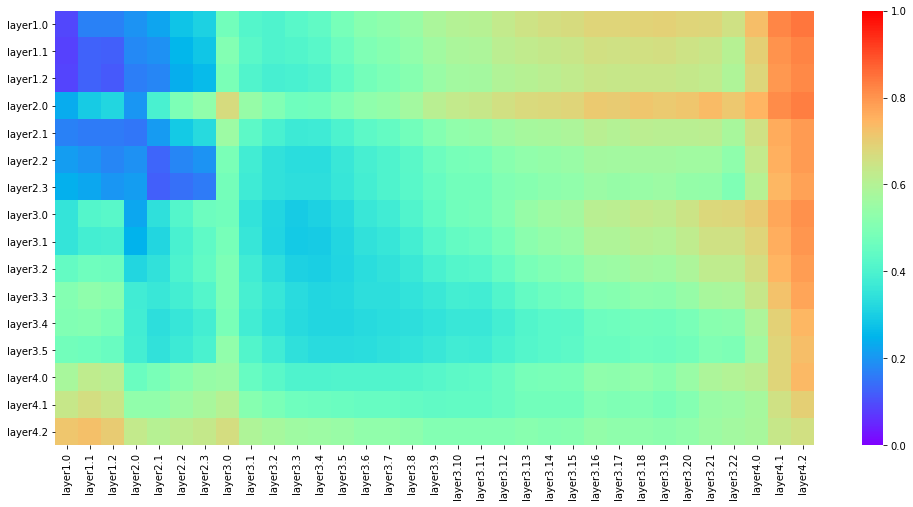

In [28]:
print("Plotting Model RDM for model -> ", model_name)
Model_RDM[np.isnan(Model_RDM)]=0.0 
ln1 = np.array(layer_names_1)
ln2 = np.array(layer_names_2)
if arch_1 == 'alexnet':
    if Model_RDM.shape[0] == 23: 
        Model_RDM = np.delete(Model_RDM,[3,15,22],0)
        ln1 = np.delete(ln1,[3,15,22],0)
plot_model = Model_RDM[0:num_layers_1,0:num_layers_2]#[model_begin_1:num_layers_1,model_begin_2:num_layers_2]
fig = plt.figure(figsize=(17,8)) #change depending on the size of the model 

ax = seaborn.heatmap(plot_model, xticklabels = ln2, yticklabels = ln1, cmap='rainbow', vmin=0.0, vmax=1.0)
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.show()

# Save as a .png file

In [29]:
path = os.path.join(ROOT_PATH + path_data_1 + 'Model_RDM_plots', getFileName("Model_RDM",NR_OF_SAMPLES,model_name,'all') + '.png')
fig.savefig(path)
path = os.path.join(ROOT_PATH + path_data_1 + 'Model_RDM_plots', getFileName("Model_RDM",NR_OF_SAMPLES,model_name,'all') + '.svg')
fig.savefig(path)

# Multidimensional scaling

In [ ]:
mds = MDS(n_components=2, n_init=200, max_iter=2000, eps=0.0001, dissimilarity='precomputed')
data_embedded = mds.fit_transform(Model_RDM)

In [ ]:
sorted_layers = [1.0,1.1,1.2,2.0,2.1,2.2,2.3,3.0,3.1,3.2,3.3,3.4,3.5,4.0,4.1,4.2]
fig = plt.figure(figsize=(8,4)) 
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=sorted_layers, cmap = 'rainbow', marker = '^')

for i in range(np.array(layer_names_1).shape[0]):
    plt.annotate(layer_names_1[i], (data_embedded[i, 0], data_embedded[i, 1]))

cbar = plt.colorbar()
# cbar.ax.set_ylabel('Layer', rotation=270)
plt.show()


In [ ]:
path = os.path.join(ROOT_PATH + path_dataset_specific +'Model_RDM_MDS', getFileName("Model_RDM_MDS_full",NR_OF_SAMPLES,model_name,layer_name_model_rdm) + '.png')
fig.savefig(path)